<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h3 style="text-align: right;">Proyecto</h3>
    </div>
    <img src="Figures\logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

En este proyecto nos interesa contestar las siguientes preguntas:

1. ¿Cuáles son los mejores y/o peores horarios para encontrar estacionaiento en Guanajuato?
2. ¿Hay alguna diferencia entre los estacionamientos del centro de Guanajuato con el resto?
3. ¿Algún estacionamiento se vería beneficiado en aumentar su capacidad?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns;
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA



np.random.seed(2025)

In [2]:
# Load the 'sat.csv' file into a DataFrame, using the first column as the index
est = pd.read_csv('disponibilidad_estacionamientos_final.csv')
MaxEst = pd.read_csv('MaxEst.csv')

# Drop any rows with missing values from the DataFrame
est = est.dropna()


In [3]:
est.head()

,Fecha_Hora,Gto-Alhondiga,Gto-Alonso,Gto-Hinojo,Gto-Pozuelos,Gto-SanPedro,Irapuato-Hidalgo,Leon-Mariachi
0,2025-02-19 15:15:15,147,32,45,475,214,178,119
1,2025-02-19 15:20:15,145,32,45,482,210,179,117
2,2025-02-19 15:25:16,149,32,44,483,212,178,120
3,2025-02-19 15:30:16,148,33,43,484,214,178,122
4,2025-02-19 15:35:17,148,37,45,490,212,176,123


In [4]:
column_names = est.columns.tolist()[1:]

print(column_names)

['Gto-Alhondiga', 'Gto-Alonso', 'Gto-Hinojo', 'Gto-Pozuelos', 'Gto-SanPedro', 'Irapuato-Hidalgo', 'Leon-Mariachi']


In [5]:
est['Fecha_Hora'] = pd.to_datetime(est['Fecha_Hora'])

In [6]:
est_ratio = np.maximum(1 - est[column_names].div(MaxEst[column_names].values, axis=1),0)

est_ratio['Date_Time'] = est['Fecha_Hora'].apply(lambda x: pd.to_datetime(x).timestamp()/(3600*24))

# Extract weekday and time into separate columns
est_ratio['Weekday'] = est['Fecha_Hora'].dt.weekday  # Monday=0, Sunday=6

est_ratio['Time'] = (est_ratio['Date_Time'] - np.floor(est_ratio['Date_Time']))


In [7]:

est_ratio['Time_sin'] = np.sin(2 * np.pi * est_ratio['Time'])
est_ratio['Time_cos'] = np.cos(2 * np.pi * est_ratio['Time'])

est_ratio['Date_Time'] = est_ratio['Date_Time'] - est_ratio['Date_Time'][0]

# Cyclic encoding for 'Weekday'
est_ratio['Weekday_sin'] = np.sin(2 * np.pi * est_ratio['Weekday'] / 7)
est_ratio['Weekday_cos'] = np.cos(2 * np.pi * est_ratio['Weekday'] / 7)

# Drop the original 'Weekday' column
est_ratio.drop(columns=['Time','Weekday'], inplace=True)


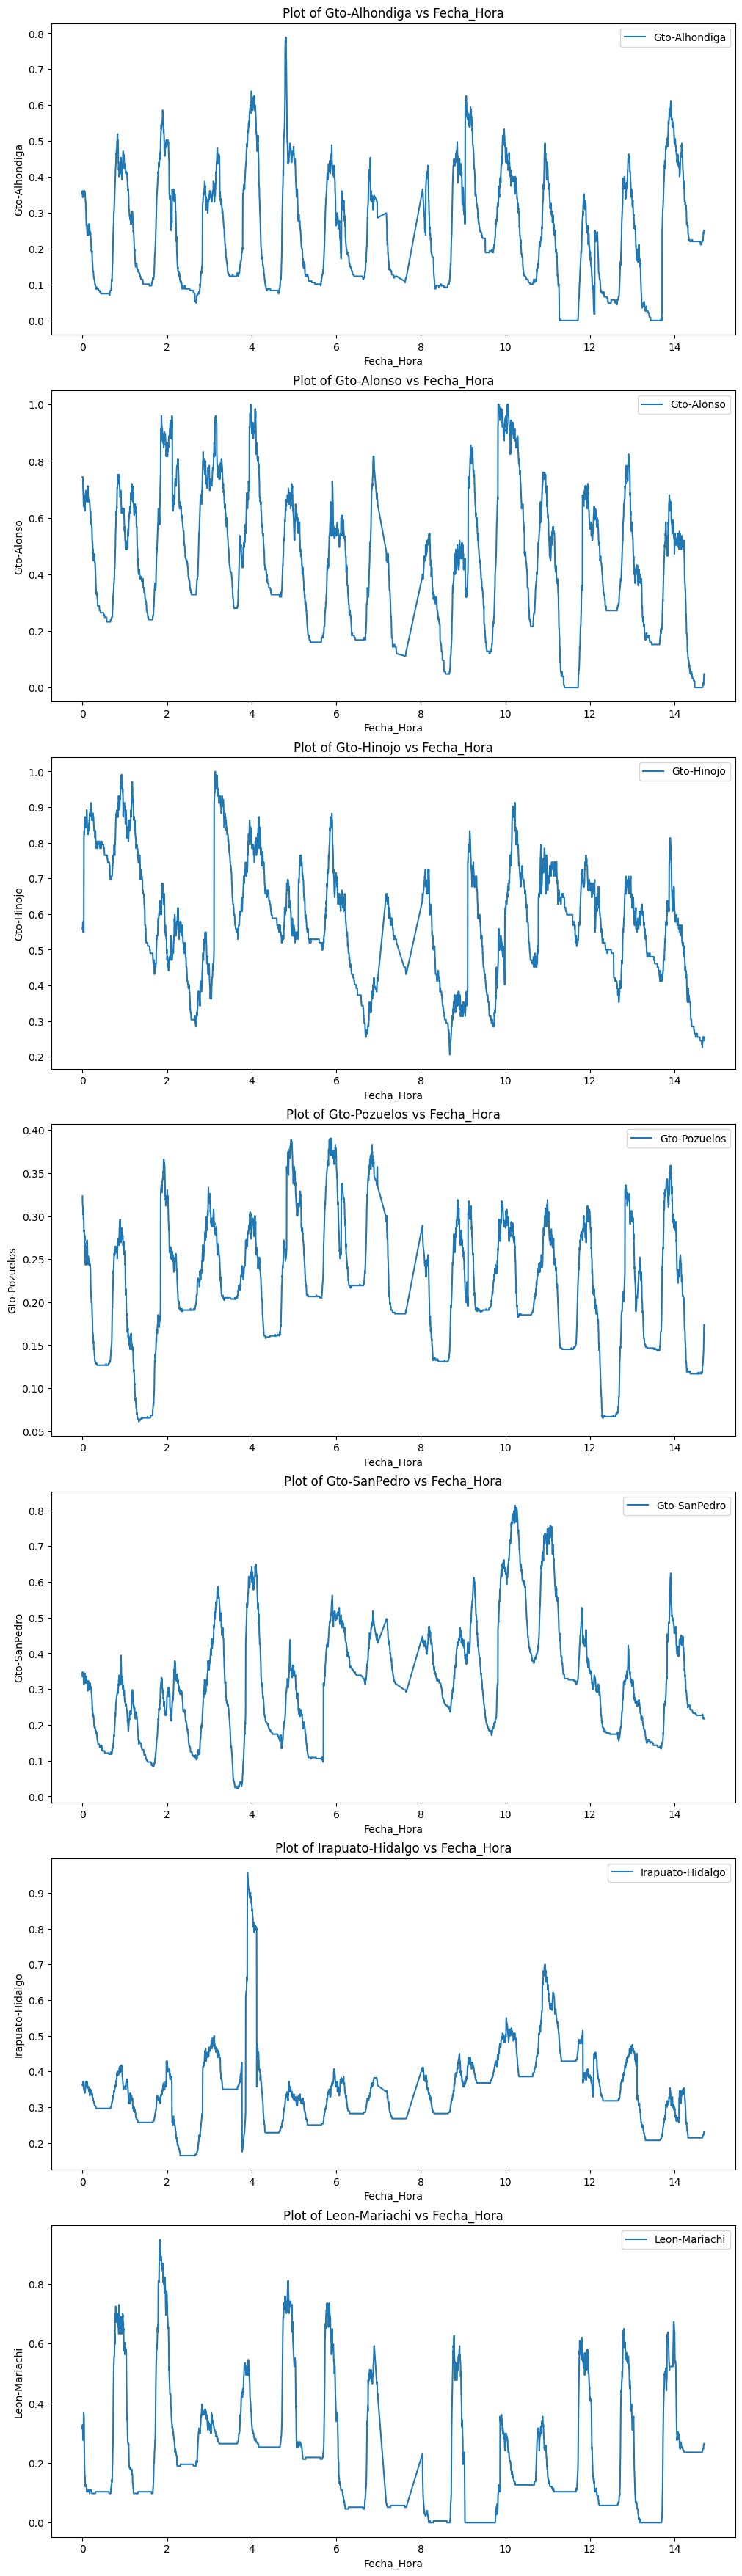

In [8]:
# Create subplots
fig, axs = plt.subplots(len(column_names), 1, figsize=(10, 5 * len(column_names)), constrained_layout=True)

# Plot each numeric column against 'Fecha_Hora'
for i, col in enumerate(column_names):
    axs[i].plot(est_ratio['Date_Time'], est_ratio[col], label=col)
    axs[i].set_title(f'Plot of {col} vs Fecha_Hora')
    axs[i].set_xlabel('Fecha_Hora')
    axs[i].set_ylabel(col)
    axs[i].legend()


In [9]:
scaler = StandardScaler()
est_scaled = scaler.fit_transform(est_ratio.drop(columns=['Date_Time']))  # Exclude Date_Time


In [20]:
# Perform PCA to reduce data to 2 dimensions
#pca = KernelPCA(n_components=2, kernel='cosine')
pca = PCA(n_components=2)
pca_data = pca.fit_transform(est_scaled)

# Create a hierarchical clustering linkage matrix using complete linkage method
pca_link = linkage(pca_data[:,:2], method = 'complete')

# Use the linkage matrix to create cluster labels
pca_labels = cut_tree(pca_link, n_clusters=4)


Modificamos la función my_plot proporcionada para que pueda mostrar los puntos con colores distintos dependiendo del agrupamiento.

In [17]:
def myplot(score,coeff,var_labels=None, points_labels=None):
    # xs and ys are the first two principal components of the score matrix
    xs = score[:,0]
    ys = score[:,1]

    # n is the number of variables in the original data set
    n = coeff.shape[0]

    # scalex and scaley are used to normalize the scores so they fit within a unit square for plotting
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # Initialize the figure
    plt.figure(figsize=(9, 6))

    # If no points_labels are provided, scatter plot all the scores using different colors
    if points_labels is None:
        plt.scatter(xs * scalex, ys * scaley, cmap='rainbow')
    else:
        # If points_labels are provided, scatter plot the scores using different colors based on their labels
        plt.scatter(xs * scalex, ys * scaley, c=points_labels, cmap='rainbow')

    # Loop through each variable in the original data set and draw an arrow pointing to its corresponding principal component
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r',alpha = 0.5)

        # If no var_labels are provided, label each principal component with the variable it corresponds to
        if var_labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            # If var_labels are provided, label each principal component with the variable name
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, var_labels[i], color = 'g', ha = 'center', va = 'center')

    # Set the x and y limits of the plot to be within a unit square for better visualization
    plt.xlim(-1,1)
    plt.ylim(-1,1)

    # Label the axes with "PC{}".format(1) and "PC{}".format(2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))

    # Show a grid on the plot for better readability
    plt.grid()

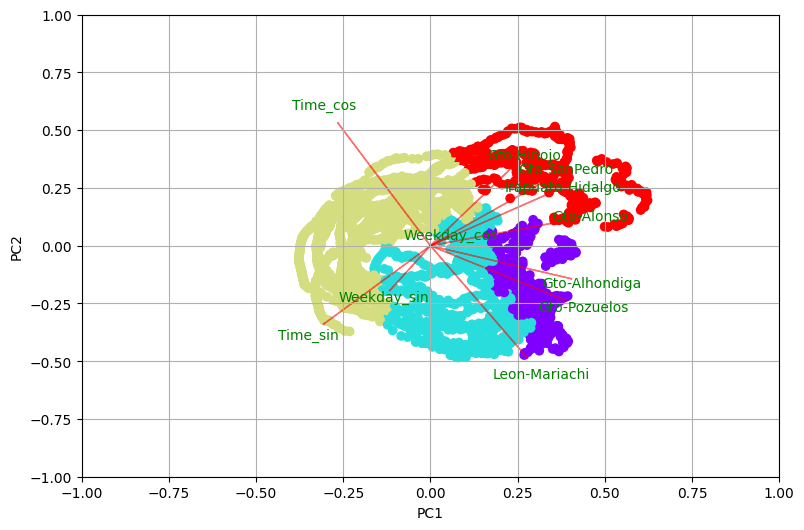

In [21]:
myplot(pca_data[:,0:2], np.transpose(pca.components_[0:2, :]), var_labels = est_ratio.drop(columns=['Date_Time']).columns.values, points_labels=pca_labels)